<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [K3GTSRB2] - First convolutions
<!-- DESC --> Episode 2 : First convolutions and first classification of our traffic signs, using Keras3
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


**IMPORTANT :** To be able to use this notebook and the following, **you must have generated the enhanced datasets** in <dataset_dir>/enhanced via the notebook **[01-Preparation-of-data.ipynb](01-Preparation-of-data.ipynb)**  

## What we're going to do :

 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

# Init Fidle environment
import fidle

run_id, run_dir, datasets_dir = fidle.init('K3GTSRB2')

<br>**FIDLE - Environment initialization**

Version              : 2.3.2
Run id               : K3GTSRB2
Run dir              : ./run/K3GTSRB2
Datasets dir         : /data/datasets-fidle
Start time           : 19/06/25 11:36:37
Hostname             : 5267531cd538 (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/K3GTSRB2/figs (False)
keras                : 3.7.0
numpy                : 2.2.1
sklearn              : 1.6.0
yaml                 : 6.0.2
matplotlib           : 3.10.0
pandas               : 2.2.3
torch                : 2.5.1+cpu


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 20% 24x24 dataset, with 5 epochs and a scale of 1, need  **3'30** on a CPU laptop.\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [2]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 5
scale         = 1
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [3]:
fidle.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale', 'fit_verbosity')

## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [4]:
def read_dataset(enhanced_dir, dataset_name, scale=1):
    '''
    Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    
        x_train,y_train, x_test,y_test data, x_meta,y_meta
    '''

    # ---- Read dataset
    #
    chrono=fidle.Chrono()
    chrono.start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]

    # ---- Rescale 
    #
    print('Original shape  :', x_train.shape, y_train.shape)
    x_train,y_train, x_test,y_test = fidle.utils.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)
    print('Rescaled shape  :', x_train.shape, y_train.shape)

    # ---- Shuffle
    #
    x_train,y_train=fidle.utils.shuffle_np_dataset(x_train,y_train)

    # ---- done
    #
    duration = chrono.get_delay()
    size     = fidle.utils.hsize(os.path.getsize(filename))
    print(f'\nDataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name, scale)

Original shape  : (7841, 24, 24, 1) (7841,)
Datasets have been resized with a factor  1
Rescaled shape  : (7841, 24, 24, 1) (7841,)
Datasets have been shuffled.

Dataset "set-24x24-L" is loaded and shuffled. (23.1 Mo in 0:00:00)


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

x_train :  (7841, 24, 24, 1)
y_train :  (7841,)
x_test  :  (2526, 24, 24, 1)
y_test  :  (2526,)


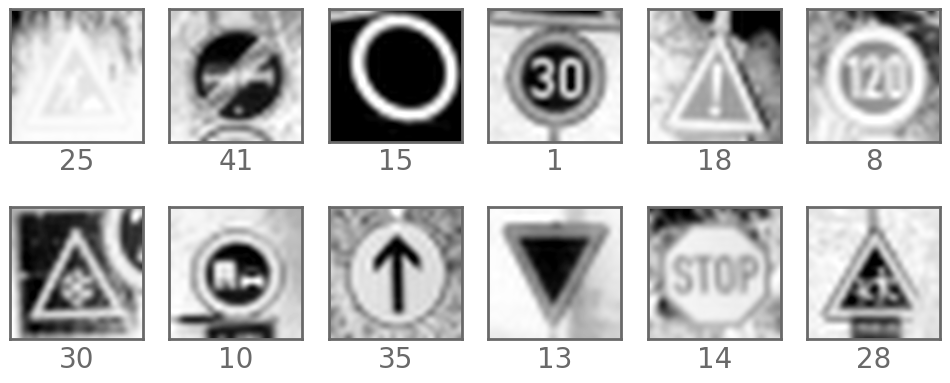

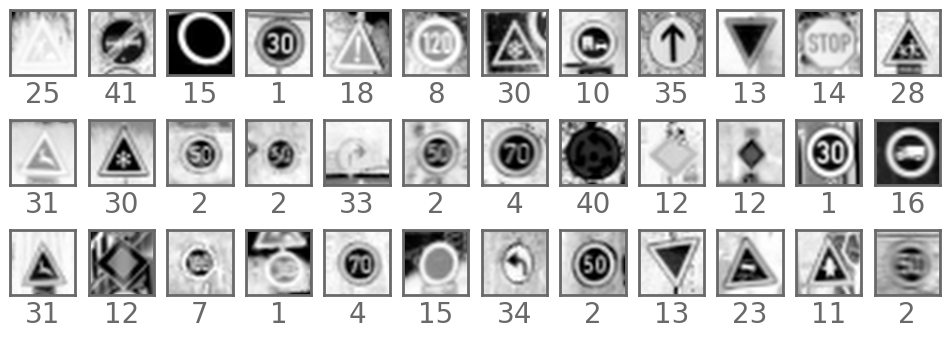

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

fidle.scrawler.images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
fidle.scrawler.images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models :

In [6]:

# ------------------------------------------------------------------
# -- A simple model, for 24x24 or 48x48 images                    --
# ------------------------------------------------------------------
#
def get_model_01(lx,ly,lz):
    
    model = keras.models.Sequential()

    model.add( keras.layers.Input((lx,ly,lz)) )
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu' ))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    

# ------------------------------------------------------------------
# -- A more sophisticated model, for 48x48 images                 --
# ------------------------------------------------------------------
#
def get_model_02(lx,ly,lz):
    model = keras.models.Sequential()
    
    model.add( keras.layers.Input((lx,ly,lz)) )
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Train the model
**Get the shape of my data :**

In [7]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_01(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 22, 22, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1500)           │     4,609,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        64,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,841,083 (18.47 MB)

 Trainable params: 4,841,083 (18.47 MB)

 Non-trainable params: 0 (0.00 B)

**Train it :**

In [9]:
chrono=fidle.Chrono()
chrono.start()

# ---- Shuffle train data
x_train,y_train=fidle.utils.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))

chrono.show()

Datasets have been shuffled.
Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1024 - loss: 3.4291 - val_accuracy: 0.4644 - val_loss: 2.0745
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5486 - loss: 1.6035 - val_accuracy: 0.7308 - val_loss: 1.0354
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7639 - loss: 0.8167 - val_accuracy: 0.8215 - val_loss: 0.7353
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8394 - loss: 0.5535 - val_accuracy: 0.8579 - val_loss: 0.5629
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8868 - loss: 0.3848 - val_accuracy: 0.8745 - val_loss: 0.4986
Duration :  24.94 seconds


## Step 5 - Evaluate

In [10]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.8745


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.4986
Test accuracy  : 0.8745


In [ ]:
fidle.end()

<div class="todo">
    What you can do:
    <ul>
        <li>Try the different models</li>
        <li>Try with different datasets</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>Create your own model</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>